## Imports

In [424]:
import copy
import glob
import importlib
import math
import os
import random
import shutil
import sys
from math import degrees, pi, radians
from os.path import *

import keras
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.morphology import ball

import cnn_builder as cbuild
import config
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.liver_metrics as lmet
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config

%matplotlib inline

In [2]:
importlib.reload(hf)
C = config.Config()

In [3]:
img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

### Corrupt data

In [7]:
big_path = r"C:\Users\Clinton\Desktop\MRI Abdomen W WO Contrast"
header = hf.dcm_load_header(big_path)

In [8]:
dcm_path = [r"C:\Users\Clinton\Desktop\New folder",
        r"C:\Users\Clinton\Desktop\New folder2",
        r"C:\Users\Clinton\Desktop\New folder3",
        r"C:\Users\Clinton\Desktop\New folder4"]

In [9]:
for i in range(4):
    os.makedirs(dcm_path[i])

In [10]:
acq_t = [124326.42, 124404.46, 124446.79, 124633.32]

In [11]:
for ix,fn in enumerate(glob.glob(join(big_path, "*"))):
    h = hf.dcm_load_header(fn)
    for i in range(4):
        if abs(float(h[0].AcquisitionTime) - acq_t[i]) < .02:
            shutil.copy(fn, join(dcm_path[i], basename(fn)))

for fn in glob.glob(join(dcm_path, "*")):
    if int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 2:
        shutil.move(fn, join(dcm_path2, basename(fn)))
    elif int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 3:
        shutil.move(fn, join(dcm_path3, basename(fn)))
    elif int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 4:
        shutil.move(fn, join(dcm_path4, basename(fn)))

In [ ]:
dim = 1
base = float(header[0].SliceLocation)
for x,h in enumerate(header[1:]):
    dz = float(h.SliceLocation) - base
    print(dz)
    base = float(h.SliceLocation)

In [412]:
fn = ["t1-pre.nii", "t1-art.nii", "t1-pv.nii", "t1-equ.nii"]

In [418]:
for i in range(2,3):
    a,dims = hf.dcm_load(dcm_path[i], True, True)
    save_path = join(dirname(dcm_path[i]), "07", fn[i])
    hf.save_nii(a, save_path, dims)

### MRI loading

In [5]:
patient_id = "01"
modality = "MRI-BL"

In [12]:
dcm_paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*")) if x.find('.')==-1]
for dcm_path in dcm_paths:
    if not exists(splitext(dcm_path)[0] + ".nii"):
        try:
            save_path = splitext(dcm_path)[0] + ".nii"
            img, dims = hf.dcm_load(dcm_path, True, True)
            hf.save_nii(img, save_path, dims)
        except:
            print(dcm_path)

2018-04-05 11:37:49,011 WARNING Slice increment not consistent through all slices
2018-04-05 11:37:49,011 WARNING ---------------------------------------------------------
2018-04-05 11:37:49,011 WARNING [-167.996496   -204.99921608    6.70226672] [ 3.7479401e-04  0.0000000e+00 -1.5000000e+00]
2018-04-05 11:37:49,017 WARNING [-167.99724559 -204.99921608    9.70226672] [ 7.4958801e-04  0.0000000e+00 -3.0000000e+00]
2018-04-05 11:37:49,018 WARNING ---------------------------------------------------------
D:\Lipiodol\Data\01\MRI-BL\T1-70s


In [12]:
paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*.nii.gz")) if '20s' in x or 'Ph1-Ax' in x]
if len(paths)==1:
    os.rename(paths[0], join(dirname(paths[0]), "mri30d_art.nii.gz"))

In [13]:
paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*.nii.gz")) \
         if ('pre' in x.lower() and 'post' not in x.lower()) or basename(x).startswith('Ax LAVA-XV')]
if len(paths)==1:
    os.rename(paths[0], join(dirname(paths[0]), "mri30d_pre.nii.gz"))

## Make liver mask

In [710]:
patient_id = "37"
mask_dir = join(target_dir, patient_id, "masks")
nii_dir = join(target_dir, patient_id, "nii_files")
if not exists(nii_dir):
    os.makedirs(nii_dir)

ct24_path = join(target_dir, patient_id, "nii_files", "ct24.nii.gz")
ct24_tumor_mask_path = glob.glob(join(mask_dir, "tumor*24h*.ids"))[0]

mribl_art_path = join(target_dir, patient_id, "MRI-BL", "mribl_art.nii.gz")
mribl_pre_path = join(target_dir, patient_id, "MRI-BL", "mribl_pre.nii.gz")
mribl_tumor_mask_path = join(mask_dir, "tumor_BL_MRI")
mribl_liver_mask_path = join(mask_dir, "mribl_liver")
mribl_enh_mask_path = join(mask_dir, "enh_bl")
mribl_nec_mask_path = join(mask_dir, "nec_bl")
ct24_bl_enh_mask_path = join(mask_dir, "ct24_bl_enh")
ct24_bl_nec_mask_path = join(mask_dir, "ct24_bl_nec")

mri30d_art_path = join(target_dir, patient_id, "MRI-30d", "mri30d_art.nii.gz")
mri30d_pre_path = join(target_dir, patient_id, "MRI-30d", "mri30d_pre.nii.gz")
mri30d_tumor_mask_path = join(mask_dir, "tumor_30dFU_MRI")
mri30d_liver_mask_path = join(mask_dir, "mri30d_liver")
mri30d_enh_mask_path = join(mask_dir, "enh_30d")
mri30d_nec_mask_path = join(mask_dir, "nec_30d")
ct24_30d_enh_mask_path = join(mask_dir, "ct24_30d_enh")
ct24_30d_nec_mask_path = join(mask_dir, "ct24_30d_nec")

In [13]:
model = keras.models.load_model(join(Config().model_dir, "mri_liver.hdf5"))

In [16]:
lm.seg_liver_mri_from_path(mri30d_art_path, mri30d_liver_mask_path, model, mri30d_tumor_mask_path)

## Non-rigid reg

In [464]:
importlib.reload(reg)

<module 'niftiutils.registration' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\registration.py'>

In [18]:
ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CT24h"), True, True)
hf.save_nii(ct_img, ct24_path, ct_dims)

In [391]:
threshold = 146.32
lmet.seg_tumor_from_threshold(mribl_art_path, mribl_pre_path,
                              threshold, mribl_tumor_mask_path,
                              mribl_enh_mask_path, mribl_nec_mask_path)
threshold = 67.810
lmet.seg_tumor_from_threshold(mri30d_art_path, mri30d_pre_path,
                              threshold, mri30d_tumor_mask_path,
                              mri30d_enh_mask_path, mri30d_nec_mask_path)

#qEASLy to produce enhancing mask
#importlib.reload(lmet)
_=lmet.segment_tumor_from_paths(mribl_art_path, mribl_pre_path,
                              mribl_liver_mask_path, mribl_tumor_mask_path,
                              mribl_enh_mask_path, mribl_nec_mask_path)
_=lmet.segment_tumor_from_paths(mri30d_art_path, mri30d_pre_path,
                              mri30d_liver_mask_path, mri30d_tumor_mask_path,
                              mri30d_enh_mask_path, mri30d_nec_mask_path)

In [17]:
xform_path, crops, pads = reg.get_mask_Tx(ct24_path, ct24_tumor_mask_path, mribl_art_path, mribl_tumor_mask_path)

# Transform using existing transform
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                     crops, pads, ct_dims, ct24_bl_enh_mask_path)
_ = reg.transform_mask(mribl_nec_mask_path, mribl_art_path, xform_path,
                     crops, pads, ct_dims, ct24_bl_nec_mask_path)

In [143]:
xform_path, crops, pads = reg.get_mask_Tx(ct24_path, ct24_tumor_mask_path, mri30d_art_path, mri30d_tumor_mask_path)

# Transform using existing transform
_ = reg.transform_mask(mri30d_enh_mask_path, mri30d_art_path, xform_path,
                     crops, pads, ct_dims, ct24_30d_enh_mask_path)
_ = reg.transform_mask(mri30d_nec_mask_path, mri30d_art_path, xform_path,
                     crops, pads, ct_dims, ct24_30d_nec_mask_path)

In [30]:
ball_ct24_path = join(target_dir, patient_id, "nii_files", "ct24_ball.nii")
ball_mribl_path = join(target_dir, patient_id, "nii_files", "mribl_ball.nii")
ball_mri30d_path = join(target_dir, patient_id, "nii_files", "mri30d_ball.nii")
ball_mask_path = join(mask_dir, "ball_mask")
ball_mribl_enh_mask_path = join(mask_dir, "ball_mribl_enh_mask")
ball_mri30d_enh_mask_path = join(mask_dir, "ball_mri30d_enh_mask")

lipiodol_mask_path = join(mask_dir, "high_lipiodol")
ball_lipiodol_mask_path = join(mask_dir, "ball_lipiodol")

In [704]:
masks.restrict_mask_to_largest(lipiodol_mask_path, lipiodol_mask_path)

In [590]:
importlib.reload(reg)

ctmask,ctd = masks.get_mask(ct24_tumor_mask_path, img_path=ct24_path)
mrmask,mrd = masks.get_mask(mribl_tumor_mask_path, img_path=mribl_art_path)
mask_scale = (ctmask.sum()*np.product(ctd) / (mrmask.sum()*np.product(mrd)))**(1/3)

xform_path, crops, pads = reg.get_mask_Tx_shape(ct24_path, ct24_tumor_mask_path, mask_scale, mask_path=ball_mask_path)
img = reg.transform_region(ct24_path, xform_path, crops, pads, [1.]*3, ball_ct24_path)
_ = reg.transform_mask(lipiodol_mask_path, ct24_path, xform_path,
                     crops, pads, [1.]*3, ball_lipiodol_mask_path)

xform_path, crops, pads = reg.get_mask_Tx_shape(mribl_art_path, mribl_tumor_mask_path, ball_mask_path=ball_mask_path)
_ = reg.transform_region(mribl_art_path, xform_path, crops, pads, [1.]*3, ball_mribl_path)
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                     crops, pads, [1.]*3, ball_mribl_enh_mask_path)

xform_path, crops, pads = reg.get_mask_Tx_shape(mri30d_art_path, mri30d_tumor_mask_path, ball_mask_path=ball_mask_path)
_ = reg.transform_region(mri30d_art_path, xform_path, crops, pads, [1.]*3, ball_mri30d_path)
_ = reg.transform_mask(mri30d_enh_mask_path, mri30d_art_path, xform_path,
                     crops, pads, [1.]*3, ball_mri30d_enh_mask_path)

## Figures

In [ ]:
# Figure for BL MRI unreg
img,_ = hf.nii_load(mribl_art_path)
blmask,_ = masks.get_mask(mribl_enh_mask_path)
nz = np.argwhere(blmask)

pad = [img.shape[0]//5, img.shape[1]//5]
sl1 = slice(max(nz[:,0].min()-pad[0],0), nz[:,0].max()+pad[0])
sl2 = slice(max(nz[:,1].min()-pad[1],0), nz[:,1].max()+pad[1])
img = np.transpose(img[sl1,sl2], (1,0,2))
blmask = np.transpose(blmask[sl1,sl2], (1,0,2))
sl1, sl2 = nz[:,-1].min(), nz[:,-1].max()

for sl in range(sl1,sl2,(sl2-sl1)//10):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray')#, vmin=30, vmax=250)
    plt.contour(blmask[:,:,sl], colors='b', alpha=.4)
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\unreg\\BLMRI_%d.png" % sl, dpi=100, bbox_inches='tight')

In [ ]:
# Figure for BL MRI unreg
img,_ = hf.nii_load(mri30d_art_path)
blmask,_ = masks.get_mask(mri30d_enh_mask_path)
nz = np.argwhere(blmask)

pad = [img.shape[0]//5, img.shape[1]//5]
sl1 = slice(max(nz[:,0].min()-pad[0],0), nz[:,0].max()+pad[0])
sl2 = slice(max(nz[:,1].min()-pad[1],0), nz[:,1].max()+pad[1])
img = np.transpose(img[sl1,sl2], (1,0,2))
blmask = np.transpose(blmask[sl1,sl2], (1,0,2))
sl1, sl2 = nz[:,-1].min(), nz[:,-1].max()

for sl in range(sl1,sl2,(sl2-sl1)//10):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray')#, vmin=30, vmax=250)
    plt.contour(blmask[:,:,sl], colors='r', alpha=.4)
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\unreg\\30dMRI_%d.png" % sl, dpi=100, bbox_inches='tight')

In [ ]:
# Figure for BL MRI unreg
img,_ = hf.nii_load(ct24_path)
blmask,_ = masks.get_mask(lipiodol_mask_path)
nz = np.argwhere(blmask)

pad = [img.shape[0]//5, img.shape[1]//5]
sl1 = slice(max(nz[:,0].min()-pad[0],0), nz[:,0].max()+pad[0])
sl2 = slice(max(nz[:,1].min()-pad[1],0), nz[:,1].max()+pad[1])
img = np.transpose(img[sl1,sl2], (1,0,2))
blmask = np.transpose(blmask[sl1,sl2], (1,0,2))
sl1, sl2 = nz[:,-1].min(), nz[:,-1].max()

for sl in range(sl1,sl2,(sl2-sl1)//5):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray', vmin=30, vmax=250)
    plt.contour(blmask[:,:,sl], colors='g', alpha=.4)
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\unreg\\Lip_%d.png" % sl, dpi=100, bbox_inches='tight')

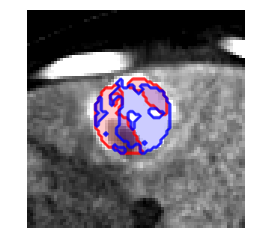

In [655]:
# Figure for 24h CT
img,_ = hf.nii_load(ball_ct24_path)
blmask,_ = masks.get_mask(ball_mribl_enh_mask_path)
fumask,_ = masks.get_mask(ball_mri30d_enh_mask_path)

for sl in range(img.shape[-1]//4,img.shape[-1]*3//4,img.shape[-1]//12):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray', vmin=30, vmax=250)
    FU=plt.contour(fumask[:,:,sl], colors='r', alpha=.4)
    plt.contour(blmask[:,:,sl], colors='b', alpha=.4)
    plt.contourf(fumask[:,:,sl], colors=[(0,0,0,0)]*6+[(1,0,0,.2)]) #look at the length of FU.allsegs
    plt.contourf(blmask[:,:,sl], colors=[(0,0,0,0)]*6+[(0,0,1,.2)])
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\24hCT_%d.png" % sl, dpi=100, bbox_inches='tight')

In [ ]:
# Figure for BL MRI
img,_ = hf.nii_load(ball_mribl_path)
blmask,_ = masks.get_mask(ball_mribl_enh_mask_path)
for sl in range(20,img.shape[-1]-20,10):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray')#, vmin=30, vmax=250)
    plt.contour(blmask[:,:,sl], colors='b', alpha=.4)
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\BLMRI_%d.png" % sl, dpi=100, bbox_inches='tight')

In [ ]:
# Figure for 24h CT Lipiodol
img,_ = hf.nii_load(ball_ct24_path)
lipmask,_ = masks.get_mask(ball_lipiodol_mask_path)
for sl in range(20,img.shape[-1]-20,10):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray', vmin=30, vmax=250)
    plt.contour(lipmask[:,:,sl], colors='g', alpha=.4)
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\Lip_24hCT_%d.png" % sl, dpi=100, bbox_inches='tight')

In [ ]:
# Figure for FU MRI

img,_ = hf.nii_load(ball_mri30d_path)
fumask,_ = masks.get_mask(ball_mri30d_enh_mask_path)
for sl in range(20,img.shape[-1]-20,10):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray')#, vmin=30, vmax=250)
    plt.contour(fumask[:,:,sl], colors='r', alpha=.4)
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\30dMRI_%d.png" % sl, dpi=100, bbox_inches='tight')

## debugging

In [270]:
fix_tmp_path="D:\\temp_fix.nii"
mov_tmp_path="D:\\temp_mov.nii"

img_m, img_m_dims = hf.nii_load(img_mov_path)
mask_m, mask_m_dims = masks.get_mask(mask_mov_path, img_m_dims, img_m.shape)

mask_m, crops_m = hf.crop_nonzero(mask_m)
img_m, _ = hf.crop_nonzero(img_m, crops_m)
img_m[mask_m == 0] = 0

R = 1.
mask_m_iso, _ = tr.rescale_img(mask_m, [R]*3, mask_m_dims)

mask_f = ball(max(mask_m_iso.shape)//2)
mask_f_iso = np.pad(mask_f, (np.ones((3,2))*5).astype(int), 'constant')
mask_m_iso, pads_m = hf.zeropad(mask_m_iso, mask_f_iso.shape, ignore_neg=True)

In [271]:
mask_m_iso.max()

255.0

In [233]:
mask_m_iso=((mask_m_iso>mask_m_iso.max()/2)*255).astype('uint8')

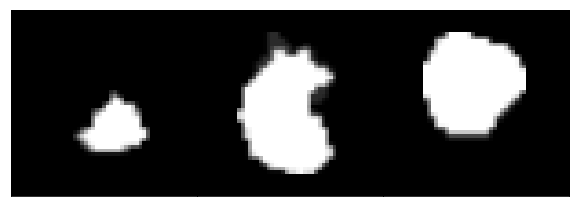

In [272]:
hf.draw_slices(mask_m_iso)

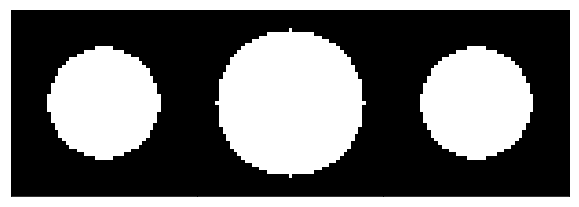

In [235]:
hf.draw_slices(mask_f_iso)

In [258]:
hf.save_nii(mask_f_iso*255, fix_tmp_path, [R]*3)
hf.save_nii(mask_m_iso, mov_tmp_path, [R]*3)

In [237]:
out_img_path="D:\\temp.nii"

In [273]:
importlib.reload(reg)
reg.reg_aligned_masks(mov_tmp_path, fix_tmp_path, out_img_path=out_img_path)

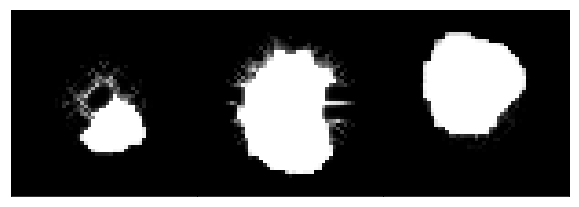

In [274]:
out_img,dims = hf.nii_load(out_img_path)
hf.draw_slices(out_img)

### Compose with rotation

In [191]:
mribl_liver_mask_path = join(target_dir, patient_id, "liver bl final.ids")
ct24_liver_mask_path = glob.glob(join(target_dir, patient_id, "wholeliver_24hCT*.ids"))[0]

In [ ]:
mribl_ct24_xform, ct24_tumor, mribl_tumor, mribl_ct24_crops = full_reg_masks(ct24_tumor_mask_path, ct24_path, mribl_tumor_mask_path, mribl_art_path)

In [ ]:
# BL MRI to 24h CT
vec_field = lm.reg_masks(ct_tumor_mask_path, blmri_tumor_mask_path)

In [ ]:
mribl_enh_mask = reg.apply_field(vec_field)

In [ ]:
ct24_lip = lm.seg_lipiodol()

In [ ]:
reg.reg_sitk(ct24_lip, vec_field)

In [114]:
mri_dcm_paths = [x for x in glob.glob(join(target_dir, '*', 'MRI-BL', '*20s*')) if '.nii' not in x]
mri_dcm_paths

In [ ]:
path_dict = {}
patient_id = '04'
for path in glob.glob(join(target_dir, patient_id, "MRI-BL","*","*")):
    header = hf.dcm_load_header(path)
    if len(header) > 0:
        series_descript = header[0][('0008', '103e')].value
        path_dict[path] = series_descript
        series_descript = series_descript.replace("/","-")
        os.rename(path, join(target_dir,patient_id, "MRI-BL", series_descript))

In [499]:
for path in glob.glob(join(target_dir, "*", "masks","*final*")):
    if not exists(path.replace(" final", "")):
        os.rename(path, path.replace(" final", ""))

for path in glob.glob(join(target_dir, "*")):
    os.makedirs(join(path, "masks"))

for path in glob.glob(join(target_dir, "*", "*.off")):
    os.rename(path, join(dirname(path), "masks", basename(path)))

### Bias field corr

In [122]:
mri_raw_paths = glob.glob(join(target_dir, '*', 'MRI-BL', 't1-art.nii.gz'))
mri_bfc_paths = [join(dirname(x), "t1-art-bfc.nii.gz") for x in mri_raw_paths]

In [176]:
importlib.reload(masks)

<module 'niftiutils.masks' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\masks.py'>

In [ ]:
glob.glob(join(target_dir, patient_id, ''

In [ ]:
masks.mask2nii()

In [128]:
inputImage = sitk.ReadImage(mri_raw_paths[0])
maskImage = sitk.OtsuThreshold( inputImage, 0, 1, 200 )

if len ( sys.argv ) > 3:
    inputImage = sitk.Shrink( inputImage, [ int(sys.argv[3]) ] * inputImage.GetDimension() )
    maskImage = sitk.Shrink( maskImage, [ int(sys.argv[3]) ] * inputImage.GetDimension() )

inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )

corrector = sitk.N4BiasFieldCorrectionImageFilter()

numberFilltingLevels = 4
#corrector.SetMaximumNumberOfIterations( [ int( sys.argv[5] ) ] *numberFilltingLevels  )

output = corrector.Execute( inputImage, maskImage )

sitk.WriteImage( output, mri_bfc_paths[0] )

# Pattern analysis

### Masks

IVs = get_intensity_section(ball_ct24_path, ball_mask_path, params)
            if highest_I_V < I_V:
                best_params = params
                highest_I_V = I_V
                print(best_params)
theta1_best, phi1_best, dtheta_best, dz_best = best_params

In [ ]:
ball_IV = get_avg_ball_intensity(ball_ct24_path, ball_mask_path)
core_IV = get_avg_core_intensity(ball_ct24_path, ball_mask_path)

In [303]:
ball_IV, core_IV

(197.83461276161094, 209.89937589866474)

In [345]:
importlib.reload(lm)
IVs = lm.calc_intensity_shells_angles(hf.nii_load(ball_ct24_path)[0], ball_mask_path)
IVs[IVs==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(IVs.shape[-1]):
    print(np.nanmean(IVs[s0,s1,i]))

227.5220951681389
213.09451872658818
226.02211229868078
212.09634566661896
150.94355531432882
102.93402318198841
93.830620161413


In [388]:
loopIVs = np.tile(IVs[:-1,:-1,:], (2,2,1))
loopIVs[180:,:,:] = np.nan

In [397]:
for dtheta in range(30,180,20):
    print(dtheta)
    best_IV = core_IV
    worst_IV = core_IV
    for theta in range(0,180,20):
        for phi in range(180,480,20):
            for shell1 in range(4):
                for shell2 in range(shell1+1,5):
                    IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, shell1:shell2])
                    params = theta, phi % 360, shell1, shell2
                    if best_IV < IV:
                        best_params = params
                        best_IV = IV
                        
            IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, :5])
            params = theta, phi % 360
            if worst_IV > IV:
                worst_params = params
                worst_IV = IV
                
    print(best_params, round(best_IV,1))
    print(worst_params, round(worst_IV,1))

30
(160, 240, 2, 3) 441.9
(40, 80) 81.8
50
(160, 240, 2, 3) 408.8
(0, 40) 84.9
70
(160, 220, 2, 3) 388.7
(0, 40) 89.2
90
(160, 220, 2, 3) 349.1
(0, 40) 99.3
110
(160, 220, 2, 3) 294.8
(0, 20) 121.9
130
(160, 240, 1, 2) 254.0
(0, 20) 150.1
150
(160, 260, 1, 2) 236.6
(0, 0) 170.4
170
(20, 260, 0, 1) 231.1
(0, 340) 188.9


In [406]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mribl_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

0.9999945327923195
0.9981377355022053
0.9981817191630961
0.986584333767749
0.9470769090679093


In [408]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mri30d_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

1.0713245377948168
1.1930964530970132
1.290257757556896
1.416016400534194
1.548997748389288


In [396]:
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

IndexError: index 180 is out of bounds for axis 0 with size 180

In [ ]:
enhmask_density =

In [ ]:
conv_rate = np.zeros((181,360))

In [ ]:
def get_conversion_rate():

In [ ]:
peripheral_density =

## Lipiodol seg

In [26]:
importlib.reload(lm)

# Lipiodol 3 masks
info = {}
for seg in glob.glob(join(mask_dir, "wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    break

In [ ]:
# Lipiodol target vs non-target masks
info = {}
for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_target_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    #break